### Starting to think a bit about trends.
1. compute some regionally-averaged metric (surface chl, NPP, etc.) 
2. plot its timeseries, 1920-2100. 
* start with the single run
* expand to include the full ensemble

I can help if you get stuck. Don't flounder around too long before asking for help.

In [1]:
%matplotlib inline
import os
import importlib
import pandas as pd
import numpy as np
import xarray as xr
import calendar
import cftime

import xesmf as xe
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import warnings
from glob import glob
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats

import util
import shutil

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [29]:
#'''
from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster
#''';

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [30]:
#'''
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client
#''';

distributed.utils - ERROR - addresses should be strings or tuples, got None
Traceback (most recent call last):
  File "/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/scheduler.py", line 2126, in remove_worker
    address = self.coerce_address(address)
  File "/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/scheduler.py", line 4836, in coerce_address
    raise TypeError("addresses should be strings or tuples, got %r" % (addr,))
TypeError: addresses should be strings or tuples, got None
distributed.core - ERROR - addresses should be strings or tuples, got None
Traceback (most recent call last):
  File "/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/core.py", line 408, in handle_comm
    result = handler(comm, **msg)
  File "/glade/work/zephyrs/miniconda

Client Scheduler: tcp://128.117.181.217:46646 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/34455/status,Cluster Workers: 7 Cores: 7 Memory: 175.00 GB


In [5]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

In [6]:
variables = ['SST', 'Chl_surf', 'KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time_bound']

In [7]:
## Clip to 1986 to 2005:
#dsm = ds[variables].isel(time=slice(1632, 1872)).groupby('time.month').mean('time')
## Clip to 1920 - end:
ds = ds[variables].isel(time=slice(840, 1872))
## Clip to 1996 to 2005:
#ds10 = ds[variables].isel(time=slice(1752, 1872))
#dsm = ds[variables].isel(time=slice(1752, 1872)).groupby('time.month').mean('time')
#dsa = ds[variables].isel(time=slice(1752, 1872)).groupby('time.year').mean('time')
#dss = ds[variables].isel(time=slice(1752, 1872)).groupby('time.season').mean('time')

## Goal: timeseries plots of DJF-mean SST and Chl
#### Method:
<https://stackoverflow.com/questions/59234745/is-there-any-easy-where-way-to-compute-seasonal-mean-with-xarray>

Using `QS-DEC` frequency will split the data into consecutive three-month periods, anchored at December 1st.

In [10]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [14]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap


def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [15]:
month_length = xr.DataArray(
    get_dpm(ds.time.to_index(), calendar='standard'),
    coords=[ds.time],
    name='month_length'
)
result = ((ds * month_length).resample(time='QS-DEC').sum() / 
          month_length.resample(time='QS-DEC').sum())


If your data has missing values, you'll need to modify this weighted mean operation to account for that (i.e. we need to mask the month_length before taking the sum in the denominator):

In [17]:
result = ((ds * month_length).resample(time='QS-DEC').sum() / 
          month_length.where(ds.notnull()).resample(time='QS-DEC').sum())

In [20]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='noleap'),
                            coords=[ds.time], name='month_length')

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby('time.season').sum(dim='time')

In [22]:
# only used for comparisons
ds_unweighted = ds.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-pack

KeyboardInterrupt: 

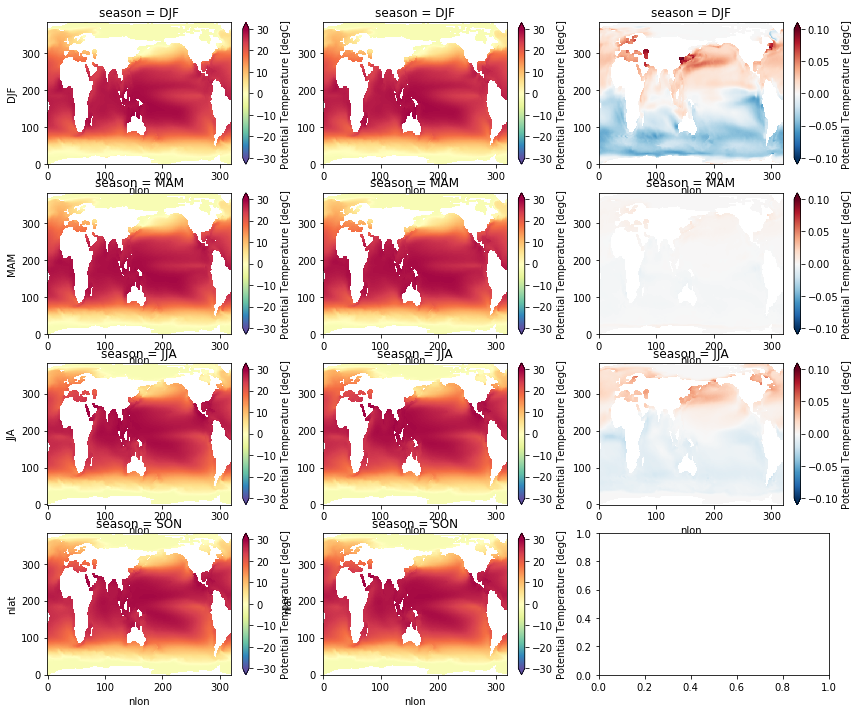

In [24]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted['SST'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['SST'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_unweighted['SST'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_diff['SST'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Seasonal SST', fontsize=16, y=1.02)

## Make Regional Masks and Check Them:

In [25]:
#make masks on grid:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)

In [26]:
# Set it up:
lat = grid.TLAT
lon = grid.TLONG

In [27]:
# Mask out rectangles:
atl_mask = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
ind_mask = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
wpac_mask = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
epac_mask = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

SO_mask = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean

In [12]:
rmask = xr.DataArray(np.ones(5), dims='region') * grid.TAREA
rmask[0, :, :] = grid.TAREA.where((lat <= -45) & (grid.REGION_MASK == 1)).fillna(0.) #Southern Ocean
rmask[1, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 295) | (lon <= 55)) & (grid.REGION_MASK == 1)).fillna(0.) # ATLANTIC
rmask[2, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 55) & (lon <= 145)) & (grid.REGION_MASK == 1)).fillna(0.) # INDIAN
rmask[3, :, :] = grid.TAREA.where((lat <= -45) & ((lon > 145) & (lon <= 245)) & (grid.REGION_MASK == 1)).fillna(0.) # WEST PACIFIC
rmask[4, :, :] = grid.TAREA.where((lat <= -45) & ((lon >= 245) & (lon <= 298)) & (grid.REGION_MASK == 1)).fillna(0.) # EAST PACIFIC

### Trim datasets to SO and regions

In [32]:
import seaborn as sns

In [37]:
#Create 1-D Array of data:
# Chl in SO (or region) monthly mean
chl_so_mean = (result.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


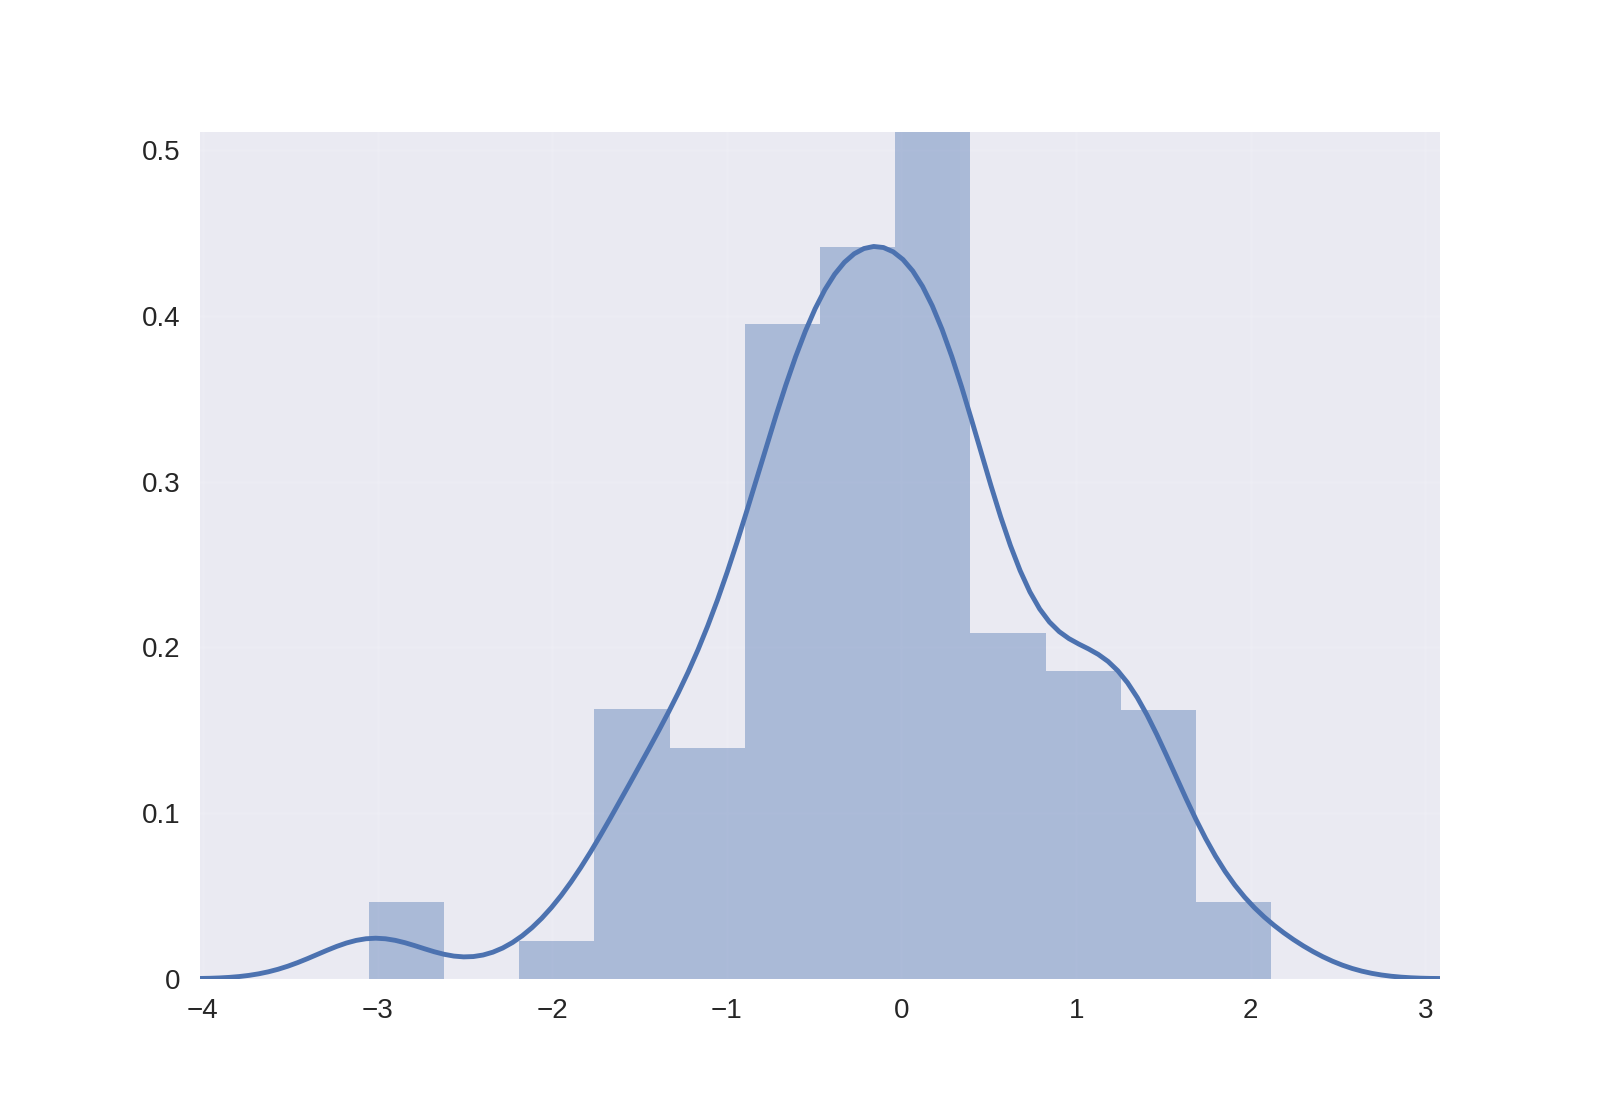

In [34]:
#1-D Array of data:


sns.distplot(x);

AttributeError: 'DataArray' object has no attribute 'TLAT'

## Decadal Distribution of Chl by Region

Create Seasonally Averaged Data

In [18]:
#using the singular masks (less computing)
chl_so_mean = (dsm.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

chl_ind_mean = (dsm.Chl_surf * ind_mask).sum(['nlat', 'nlon']) / ind_mask.sum(['nlat', 'nlon'])
chl_ind_mean = chl_ind_mean.compute()

chl_atl_mean = (dsm.Chl_surf * atl_mask).sum(['nlat', 'nlon']) / atl_mask.sum(['nlat', 'nlon'])
chl_atl_mean = chl_atl_mean.compute()

chl_wpac_mean = (dsm.Chl_surf * wpac_mask).sum(['nlat', 'nlon']) / wpac_mask.sum(['nlat', 'nlon'])
chl_wpac_mean = chl_wpac_mean.compute()

chl_epac_mean = (dsm.Chl_surf * epac_mask).sum(['nlat', 'nlon']) / epac_mask.sum(['nlat', 'nlon'])
chl_epac_mean = chl_epac_mean.compute()

In [ ]:
chl_so_mean = (dsm.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

In [27]:
#Log transform the data
log_trans = np.log10(chl_atl_mean)

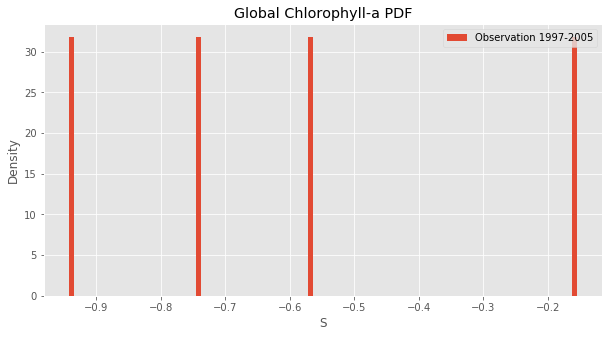

### Calc Regional Means


In [20]:
#Using the rmask ds....
sst_so_mean = (ds.SST * rmask.isel(region=0)).sum(['nlat', 'nlon']) / rmask.isel(region=0).sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()

sst_atl_mean = (ds.SST * rmask.isel(region=1)).sum(['nlat', 'nlon']) / rmask.isel(region=1).sum(['nlat', 'nlon'])
sst_atl_mean = sst_atl_mean.compute()

sst_ind_mean = (ds.SST * rmask.isel(region=2)).sum(['nlat', 'nlon']) / rmask.isel(region=2).sum(['nlat', 'nlon'])
sst_ind_mean = sst_ind_mean.compute()

sst_wpac_mean = (ds.SST * rmask.isel(region=3)).sum(['nlat', 'nlon']) / rmask.isel(region=3).sum(['nlat', 'nlon'])
sst_wpac_mean = sst_wpac_mean.compute()

sst_epac_mean = (ds.SST * rmask.isel(region=4)).sum(['nlat', 'nlon']) / rmask.isel(region=4).sum(['nlat', 'nlon'])
sst_epac_mean = sst_epac_mean.compute()

In [ ]:
#using the singular masks (less computing)
chl_so_mean = (result.Chl_surf * SO_mask).sum(['nlat', 'nlon']) / SO_mask.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

chl_ind_mean = (result.Chl_surf * atl_mask).sum(['nlat', 'nlon']) / atl_mask.sum(['nlat', 'nlon'])
chl_ind_mean = chl_ind_mean.compute()

chl_atl_mean = (result.Chl_surf * ind_mask).sum(['nlat', 'nlon']) / ind_mask.sum(['nlat', 'nlon'])
chl_atl_mean = chl_atl_mean.compute()

chl_wpac_mean = (result.Chl_surf * wpac_mask).sum(['nlat', 'nlon']) / wpac_mask.sum(['nlat', 'nlon'])
chl_wpac_mean = chl_wpac_mean.compute()

chl_epac_mean = (result.Chl_surf * epac_mask).sum(['nlat', 'nlon']) / epac_mask.sum(['nlat', 'nlon'])
chl_epac_mean = chl_epac_mean.compute()

In [25]:
sst_atl_mean = (ds.SST * atl_mask).sum(['nlat', 'nlon']) / atl_mask.sum(['nlat', 'nlon'])
sst_atl_mean = sst_atl_mean.compute()

sst_ind_mean = (ds.SST * ind_mask).sum(['nlat', 'nlon']) / ind_mask.sum(['nlat', 'nlon'])
sst_ind_mean = sst_ind_mean.compute()

sst_wpac_mean = (ds.SST * wpac_mask).sum(['nlat', 'nlon']) / wpac_mask.sum(['nlat', 'nlon'])
sst_wpac_mean = sst_wpac_mean.compute()

sst_epac_mean = (ds.SST * epac_mask).sum(['nlat', 'nlon']) / epac_mask.sum(['nlat', 'nlon'])
sst_epac_mean = sst_epac_mean.compute()

### Plot Chl
style.use('ggplot')
sns.set_style("darkgrid")

In [19]:
import seaborn as sns
#sns.set_style("darkgrid")
#style.use('seaborn')
style.use('ggplot')

In [15]:
#for saving figures:
pwd = os.getcwd()
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

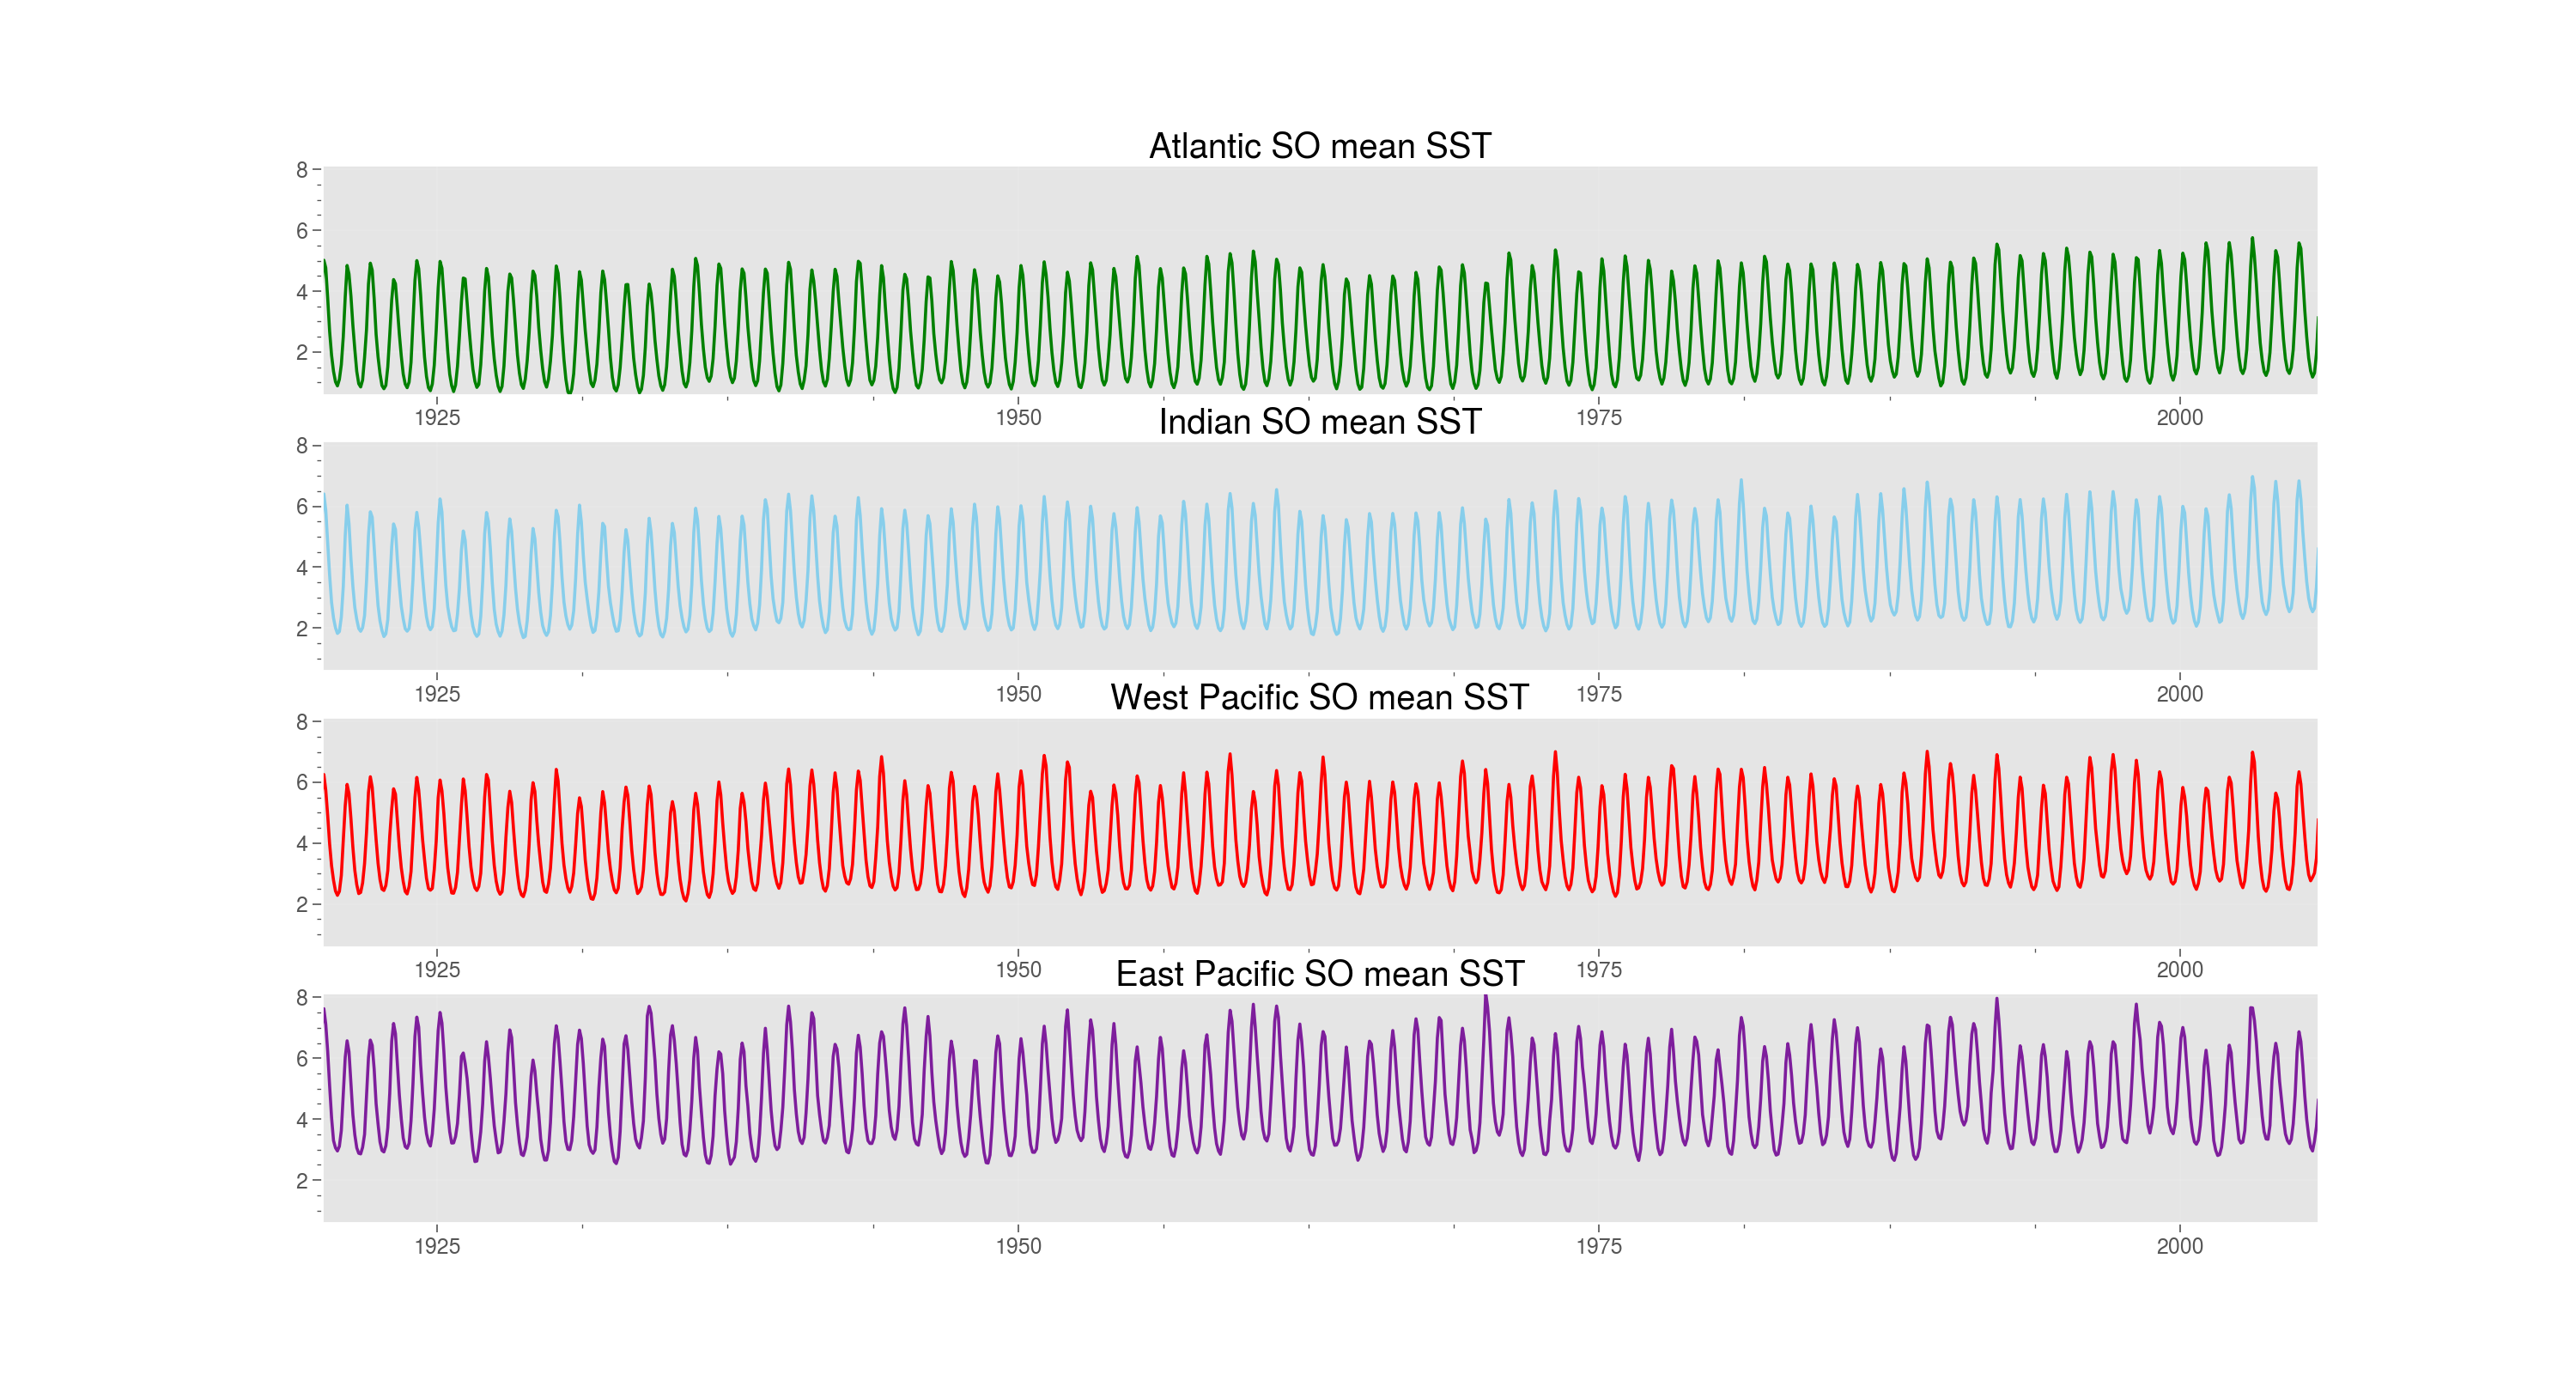

In [21]:
# Plot all Basins
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(414)
ax1.set_title('East Pacific SO mean SST')
ax1.plot(sst_epac_mean['time'].values, sst_epac_mean.values, color = 'purple')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean SST')
ax2.plot(sst_ind_mean['time'].values, sst_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(411,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean SST')
ax3.plot(sst_atl_mean['time'].values, sst_atl_mean.values, color = 'green')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('West Pacific SO mean SST')
ax3.plot(sst_wpac_mean['time'].values, sst_wpac_mean.values, color = 'red')
plt.gca()

plt.savefig('CESM-SST-TIMESERIES-BYBASIN-INDIVID.png')

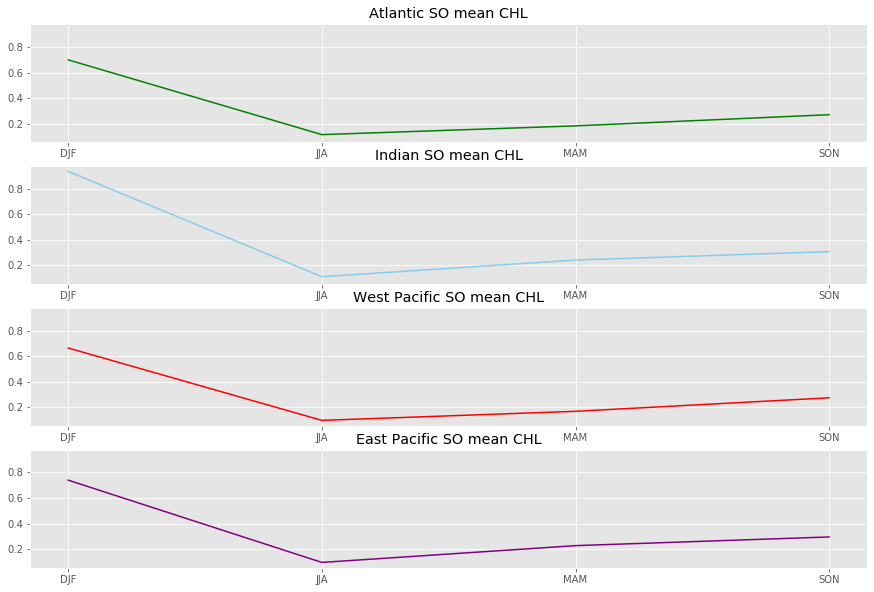

In [24]:
# Plot all Basins
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(414)
ax1.set_title('East Pacific SO mean CHL')
ax1.plot(chl_epac_mean['season'].values, chl_epac_mean.values, color = 'purple')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean CHL')
ax2.plot(chl_ind_mean['season'].values, chl_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(411,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean CHL')
ax3.plot(chl_atl_mean['season'].values, chl_atl_mean.values, color = 'green')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('West Pacific SO mean CHL')
ax3.plot(chl_wpac_mean['season'].values, chl_wpac_mean.values, color = 'red')
plt.gca()

#plt.savefig('CESM-CHL-BYBASIN_Season.png')

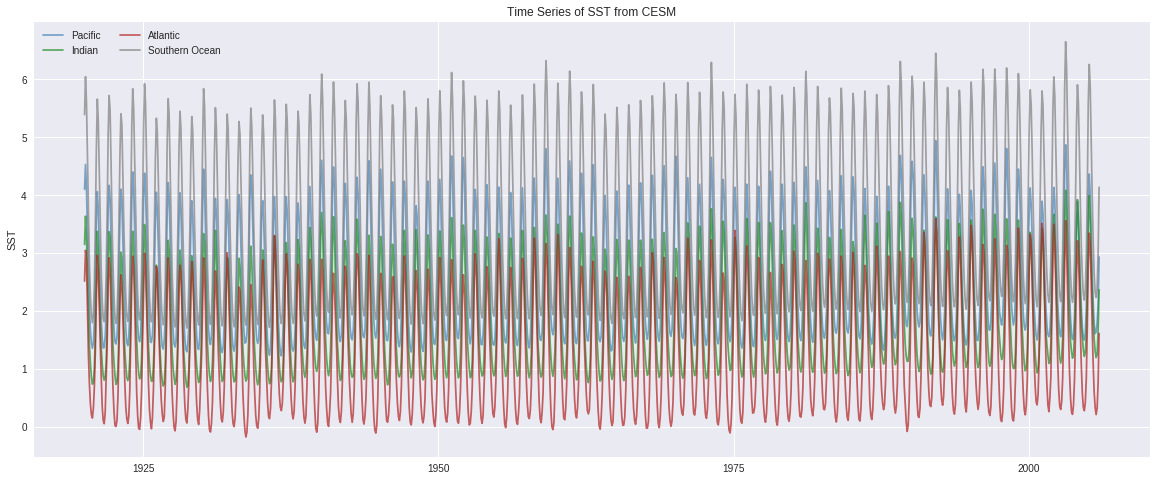

In [138]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
ax.set_title('Time Series of SST from CESM')

ax.plot(sst_pac_mean['time'].values, sst_pac_mean.values, alpha=0.7, label = 'Pacific', color = 'steelblue')
ax.plot(sst_ind_mean['time'].values, sst_ind_mean.values, alpha=0.7, label = 'Indian', color = 'forestgreen')
ax.plot(sst_atl_mean['time'].values, sst_atl_mean.values, alpha=0.7, label = 'Atlantic', color = 'firebrick')
ax.plot(sst_so_mean['time'].values, sst_so_mean.values, alpha=0.7, label = 'Southern Ocean', color = 'grey')

ax.legend(ncol=2)
ax.set(ylabel='SST')
plt.gca()

#plt.savefig('CESM-SST-TIMESERIES-BYBASIN.png')

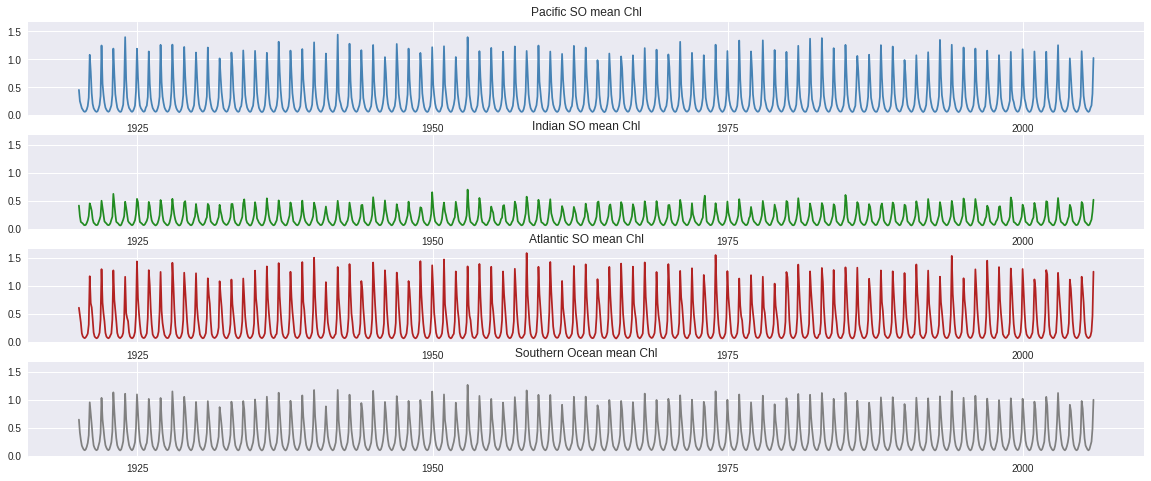

In [145]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(411)
ax1.set_title('Atlantic SO mean Chl')
ax1.plot(chl_atl_mean['time'].values, chl_atl_mean.values, color = 'green')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean Chl')
ax2.plot(chl_ind_mean['time'].values, chl_ind_mean.values, color = 'skyblue')
plt.gca()

ax3 = fig.add_subplot(413, sharex=ax1, sharey=ax1)
ax3.set_title('Pacific SO mean Chl')
ax3.plot(chl_pac_mean['time'].values, chl_pac_mean.values, color = 'red')
plt.gca()

ax4 = fig.add_subplot(414, sharex=ax1, sharey=ax1)
ax4.set_title('Pacific SO mean Chl')
ax4.plot(chl_pac_mean['time'].values, chl_pac_mean.values, color = 'purple')
plt.gca()

#plt.savefig('CESM-CHL-TIMESERIES-BYBASIN-INDIVID.png')

## Trends?


Make two maps: one of annual mean surface temperature, another of the seasonal range (max minus min).

In [1]:
cluster.close()
client.close()

NameError: name 'cluster' is not defined

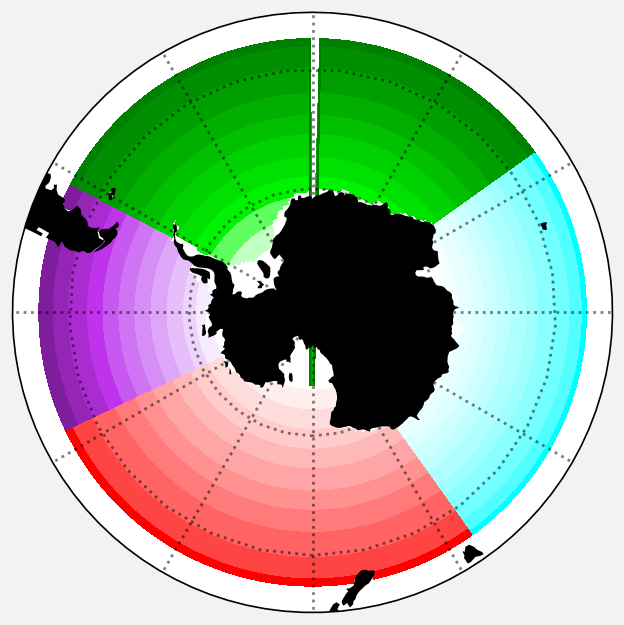

In [22]:
#TO VISUALIZE MASKS:
#Polar Plotting THIS IS WRONG:
threshold = 1.0
atl_mask_filtered = atl_mask.values.copy()
atl_mask_filtered[atl_mask_filtered < threshold] = np.nan

threshold = 1.0
ind_mask_filtered = ind_mask.values.copy()
ind_mask_filtered[ind_mask_filtered < threshold] = np.nan

threshold = 1.0
wpac_mask_filtered = wpac_mask.values.copy()
wpac_mask_filtered[wpac_mask_filtered < threshold] = np.nan

threshold = 1.0
epac_mask_filtered = epac_mask.values.copy()
epac_mask_filtered[epac_mask_filtered < threshold] = np.nan
import proplot as plot
#check all region masks are correct:

#Polar Plot:

f, axs = plot.subplots(ncols=1, proj = 'splaea', axwidth=3)

axs.pcolormesh(lon, lat, atl_mask_filtered, cmap='green', label = 'Atlantic')
axs.pcolormesh(lon, lat, ind_mask_filtered, cmap='cyan', label = 'Indian')
axs.pcolormesh(lon, lat, wpac_mask_filtered, cmap='red', label = 'West Pacific')
axs.pcolormesh(lon, lat, epac_mask_filtered, cmap='purple',label = 'East Pacific')

axs.format(boundinglat=-40, land = True)